# Simple Example of State Space Control
We will control a series RC circuit as shown here.

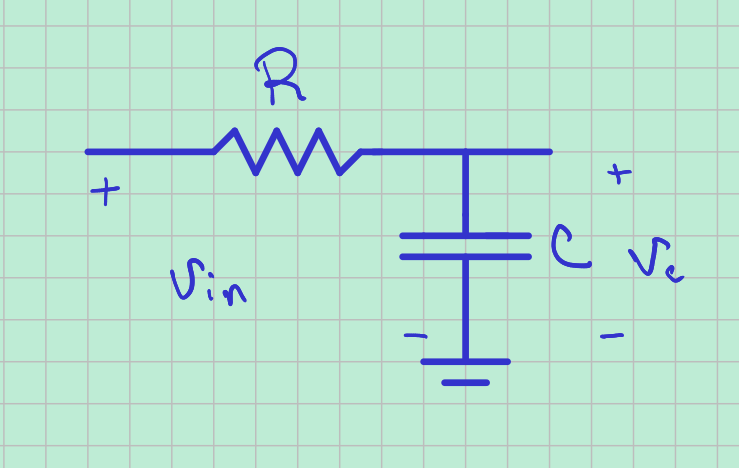 

Writing the circuit equation we have:  $$C \frac{dv_c} {dt} = \frac{(v_{in}-v_c)}{R} $$ which in state form gives us  $$\dot v_c = [-1/(RC)]v_c + [1/(RC)]v_{in}$$ and from this we see that $\mathbf A = [-1/(RC)]$, $\mathbf B = [1/(RC)]$, and $\mathbf C = 1$.  The eigenvalue of the system is $-1/(RC)$.  The input $\mathbf u = v_{in}$, and the output is taken to be the capacitor voltage.  We know analytically the capacitor voltage time response to the initial condition, is $$v_c(t) =  v_c(0) e^{-t/(RC)}$$.  We simulate that below in python.

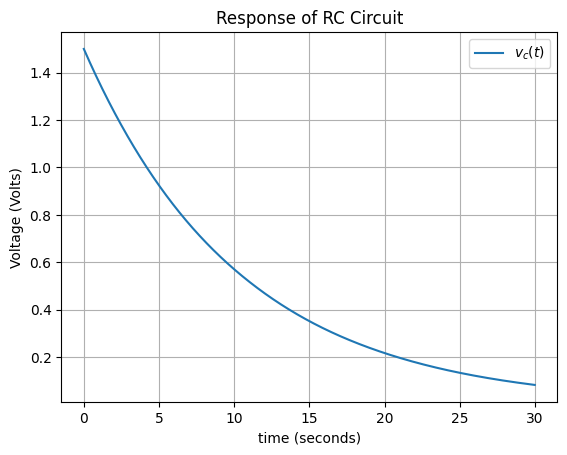

The eigenvalue is:  -0.09671179883945842
numpy gives the eigenvalue, and eigen vector respectively as: 


(array([-0.0967118]), array([[1.]]))

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control as ctrl

R = 22e3
C = 470e-6

circuit = ctrl.ss(-1/(R*C), 1/(R*C), 1, 0)
t = np.arange(0, 30, 0.01)
u = np.zeros(len(t))
x0 = 1.5
t, vc = ctrl.input_output_response(circuit, t, u, x0)
plt.plot(t,vc)
plt.grid()
plt.title("Response of RC Circuit")
plt.legend(["$v_c(t)$"])
plt.xlabel("time (seconds)")
plt.ylabel("Voltage (Volts)")
plt.show()
print("The eigenvalue is: ",-1/(R*C))
print("numpy gives the eigenvalue, and eigen vector respectively as: ")
np.linalg.eig(circuit.A)

## Fitting the Model
We want to fit the model parameters to try and get them as close to right as we can.  To do this, we will need to collect data for the fit.  We will use [6302view](https://github.com/almonds0166/6302view), which is software for the Arduino or ESP32 that allows us to easily collect and display data that the microcontroller is measuring or exciting our plant with.  Then we will use a python script to fit our model and obtain the best $RC$ parameter value.  We can then compare it to the value we got by measuring the resistance and capacitance.  One thing you learn when doing control system models is you need to find multiple ways of verifying the model.  This will serve as one for us.

### Linearize the Model
We need to think about this carefully, because the DAC can only put out voltages in the range $(0,3.3)$ volts and not source more that 12mA of current.  These restrictions mean the resistance must be bigger than $3.3V/12mA = 275 \Omega$.    This is why we feed in a square wave above with an amplitude about $1.4$ volts centered on $3.3V/2$, and why we picked $R = 22k\Omega$ and $C = 470 uF$
.  The DAC voltages are set by the integers in the interval $(0, 255)$, so the scale factor for DAC number to voltage is $256/3.3$ counts per volt.

### First steps:  Set up the Circuit and the software to drive the RC Circuit and Measure the Results With [6302view](https://github.com/almonds0166/6302view)
Our goal is now to get the actual hardware going so that we can measure the output as a function of the input.  The first use we will make of that ability is to collect data to verify and perhaps modify our model with.  This section shows how to use [6302view](https://github.com/almonds0166/6302view) and the ESP32 to do that.

Here is the code for the MCU:

To make this work, you build the above Arduino code for the ESP32 board, connect the RC filter to the ESP32 as shown in this photo.  The ESP32 I had handy is the 30 pin ESP32 Dev Module.  You may need to adjust the pin locations based on the ESP32 you have.  

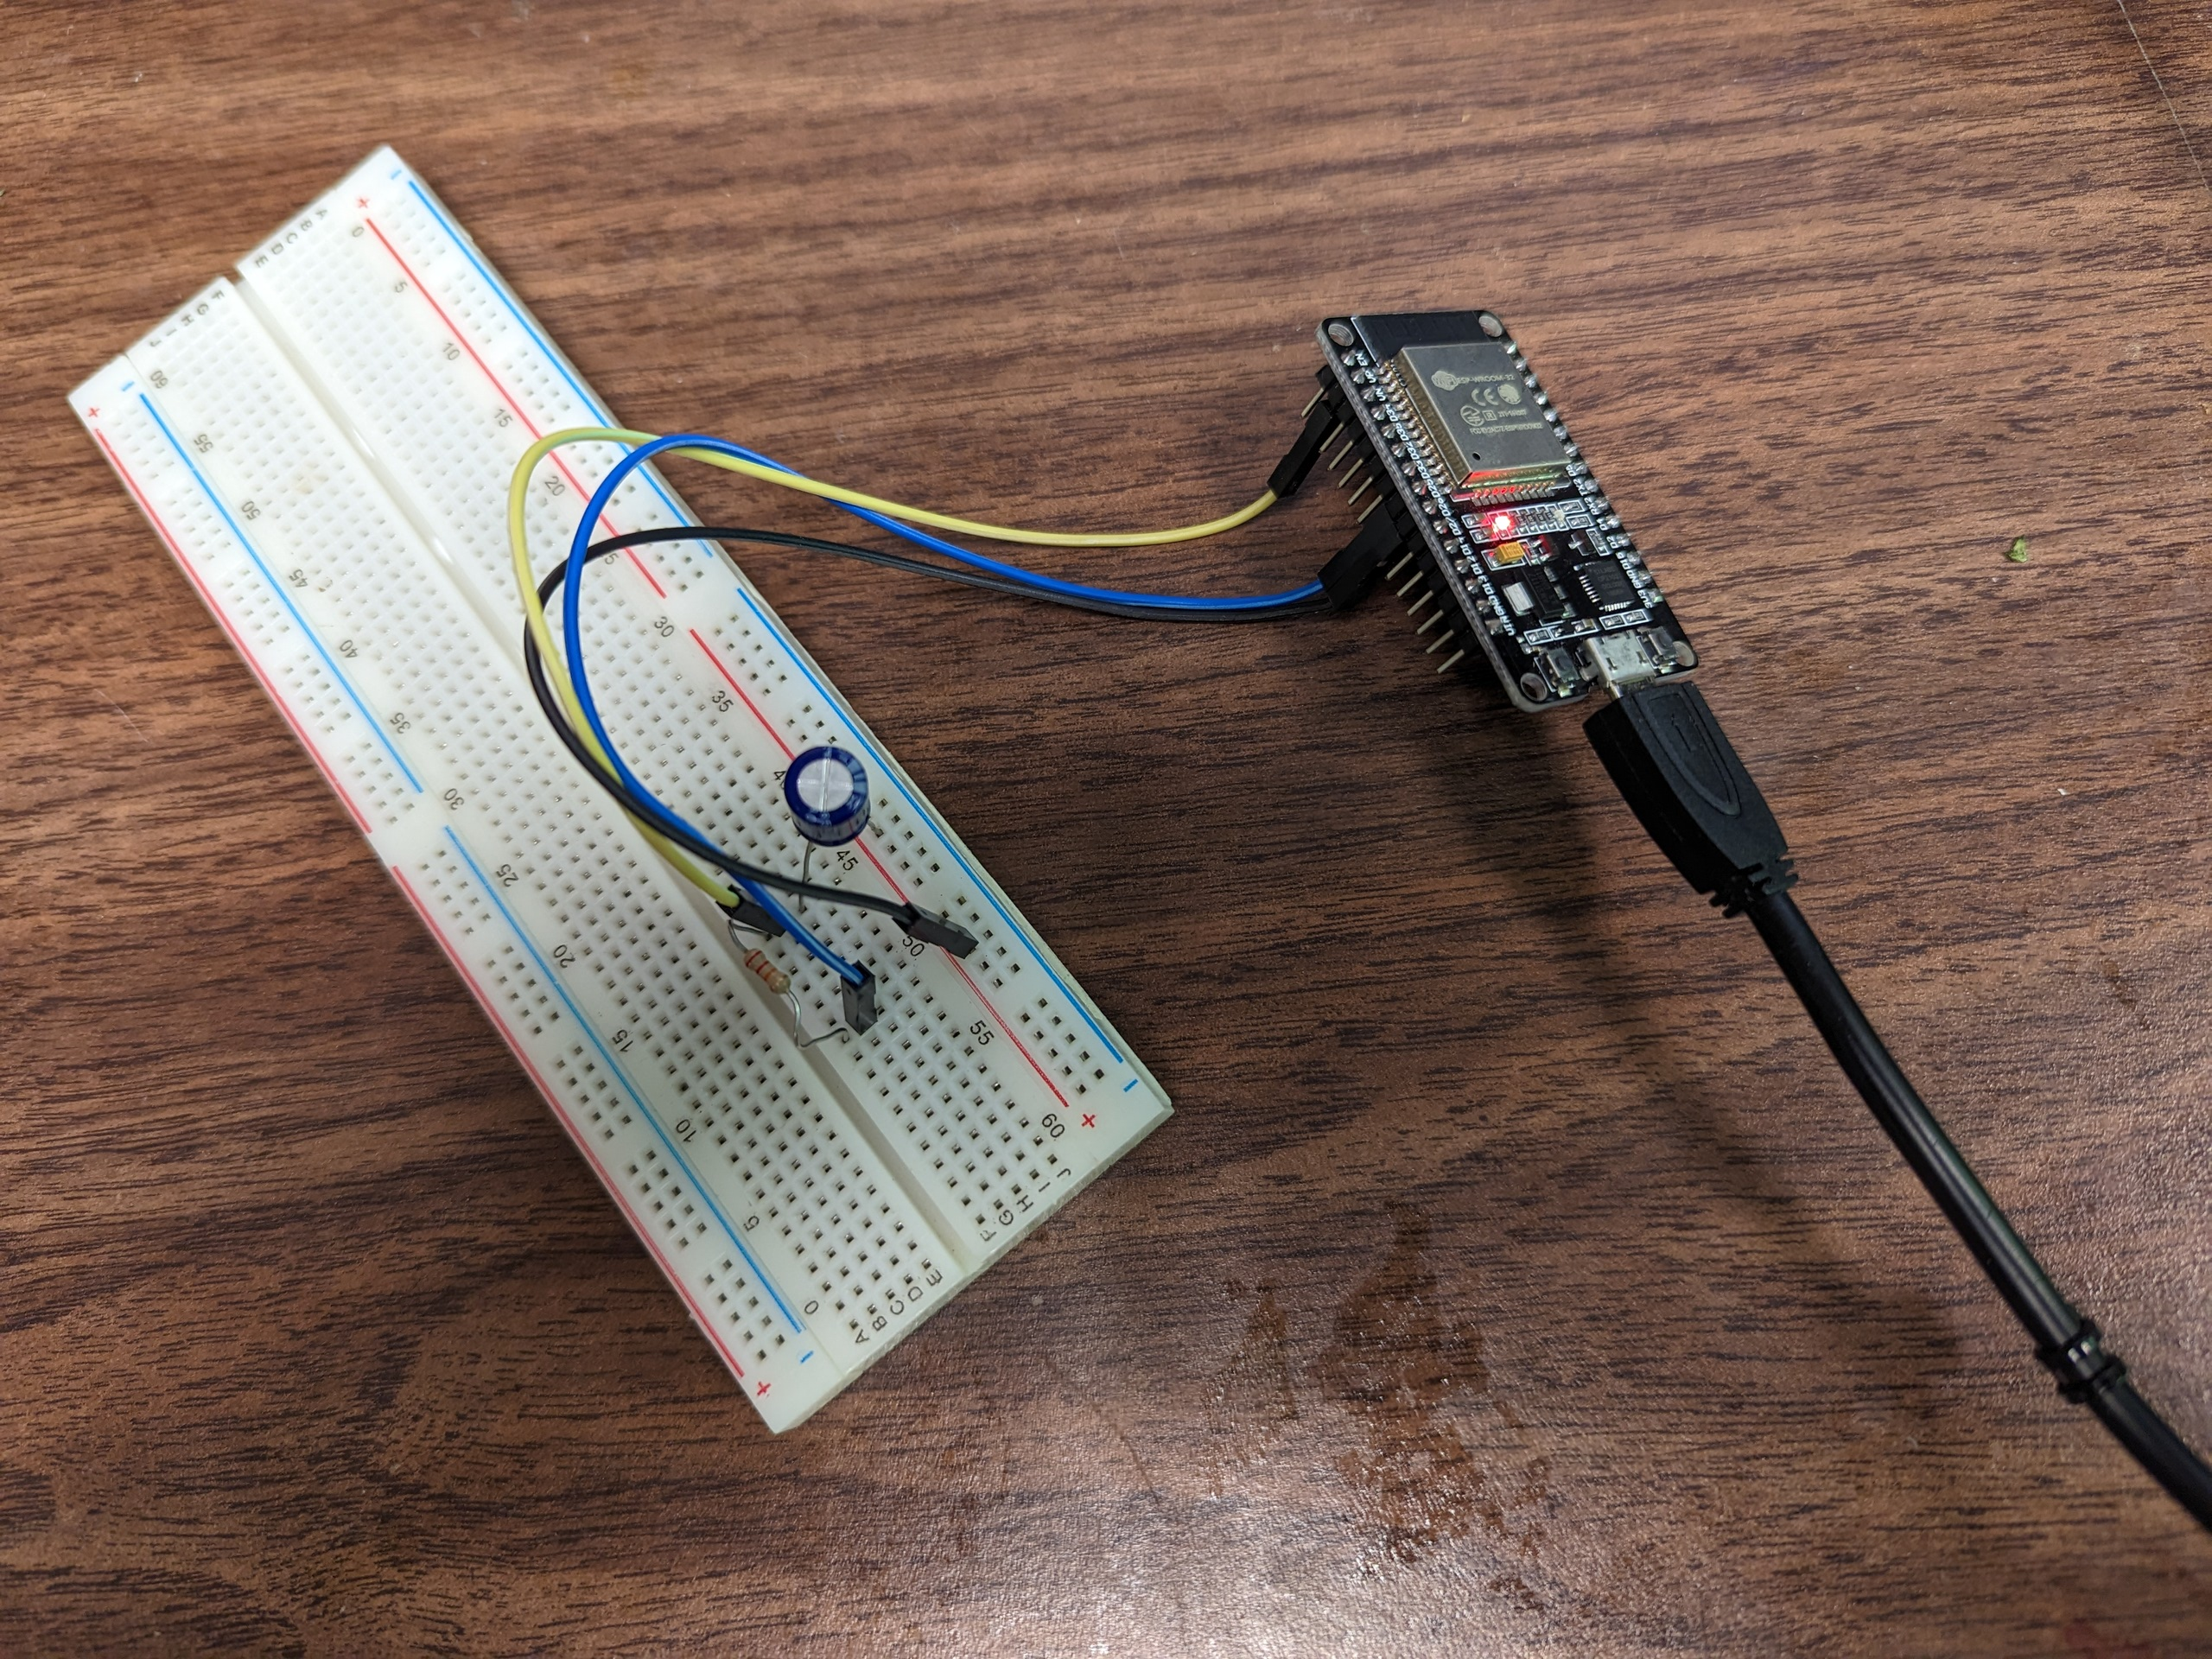

Then run the python script that acts as the webserver, as shown here.  

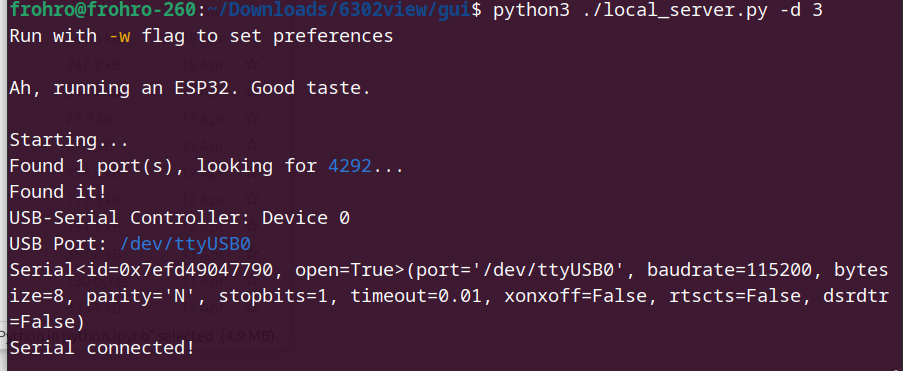 

Then open the gui.html in your browser and hit the connect button.  The results look something like this:  

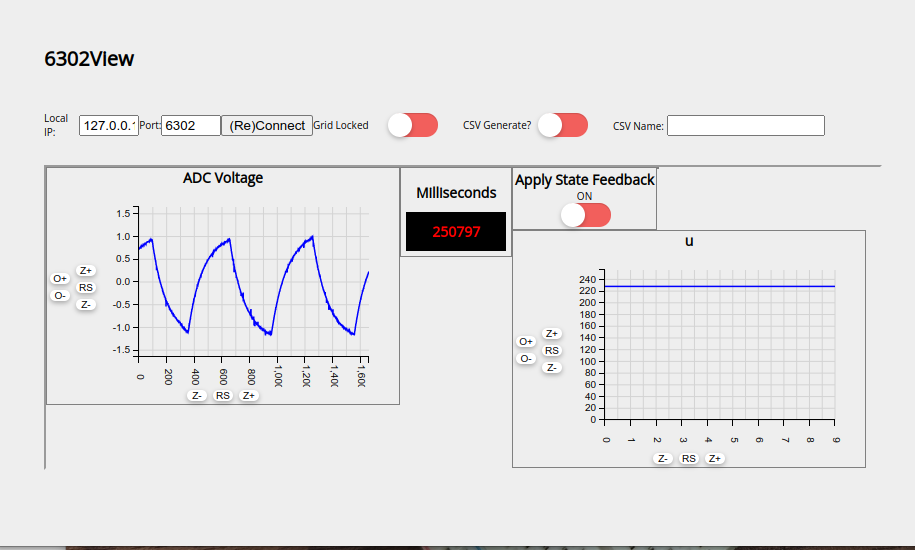 

There is a button on that webpage that allows you to save the data to a CSV file for processing outside of 6302view.  You slide the CSV File button to the right, and wait until the data you want gets collected, then slide the button back to the left, and your CSV file is then saved in the Downloads folder of your computer.

Now we can actually use curve-fitting to find the $RC$ parameter.

   v_c (Volts)  v_{in} (V)   Time (s)
0     0.749268   -1.289062  31.693001
1     0.698511   -1.289062  31.792999
2     0.671118   -1.289062  31.893000
3     0.704150   -1.289062  31.993000
4     0.655811   -1.289062  32.094002
Best-fit parameters for v_c (Volts): [31.41675226  0.08593393 -1.32656151]


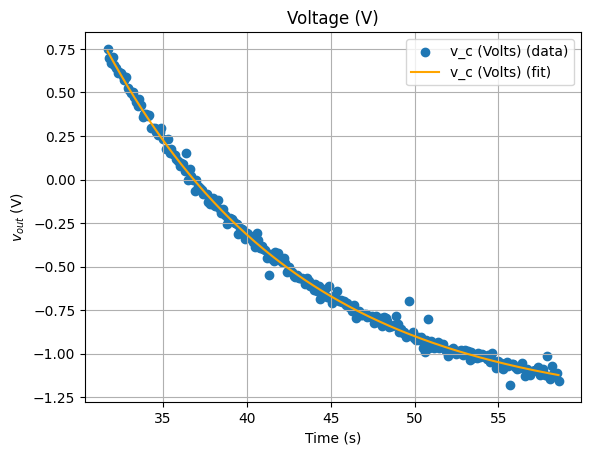

The best fit RC parameter is:  11.636847559668043 seconds.


In [2]:
%run "RC Curve Fit.ipynb"

### State Feedback
First we need to make sure the system is controllable.  Then we need to set the poles or eigenvalues by applying state feedback.  Since we are measuring the state variable, the capacitor voltage as our output this is straight-forward.  In cases where that is not done, the state variables can be simulated using an observer as shown [below](#observer).

#### Checking to Make Sure the System is Controllable
To do this, we need measurements the state variable, and the ability to control the input to the system.  This is pretty simple with a single state system like our RC circuit, but may not be with a more complicated system.  We are doing this toy design to learn the tools, so we need to check the controllability matrice's ranks.  Here is how you do that in python.

In [3]:
Q = ctrl.ctrb(circuit.A, circuit.B)
print("Q is: ", Q)
print("Rank of Q is: ", np.linalg.matrix_rank(Q))

Q is:  [[0.0967118]]
Rank of Q is:  1


So we see that this system is controllable and observable if we measure the capacitor voltage, $v_c$, and control the input voltage, $v_{in}$, which we have demonstrated how to do above.

Suppose we want to make the response ten times as fast.  $|s\mathbf I - (\mathbf {A 
-BG}) | = 0 = s+10/(RC)$ which means $G = 2/RC$. So $$s+1/(RC) + [9/(RC)]G = s+10/(RC)$$ which simplifies to $$ 1 +G = 10$$ or $$G = 9$$ We will use the ESP32 which has an ADC and a DAC.  The ADC gives 12 bits and we will used ADC0 on pin 36. DAC1 and DAC2 are 8 bits on pin 25 and 26 respectively.  We will use one to do the control and the other as a quasi-ground, "GND" at $3.3V/2$.   The MCU will only put out and measure positive voltages, but we need to have bipolar capability for our feedback to coast back to zero output, so we will use one DAC for the driving voltage source, $v_{in}$ and another DAC to supply $3.3V/2$ to the "GND" side of our capacitor, thus raising all the voltages up by $3.3V/2$, so the MCU can have an essentially bipolar output.  Essentially what we are doing here is a "linearization" about the operating point of $3.3V/2$.  The MCU is nice and linear between ground and $3.3V$.

We will use the 6302view software to set the sample rate and to collect and view all the variables we care about. 

Note:  It is tempting to try and use a square wave to set up the initial condition, and let it coast between the two values of the square wave, and then simply switch feedback off and on for comparison.  The problem with this is that the DC level that the circuit settles to is different with and without feedback.  This works for a simple RC circuit, because the DC gain is unity, however, since the DC gain after applying feedback is less than unity, and varies with the amount of feedback employed, it is very hard to see how the exponential decay compares in both situations.  Because of this, we will set up the initial condition without feedback using a square wave from the MCU, and then 
let the system coast from that initial condition to our zero, "GND", the $3.3V/2$ voltage.  So feedback will only be applied on falling on the falling response.  That way you can compare the rising response to the falling response.  I will also provide a way to turn feedback off for both rising and falling responses.

Now let's get python to give us the gain matrix, $\mathbf G$.

In [4]:
G = ctrl.place(circuit.A, circuit.B, -10/R/C)
print(G)

[[9.]]


### Add State Feedback to the RC Circuit
The foregoing demonstration allows us to experimentally measure the response of our RC circuit system to a square wave input signal, and by switching the toggle, state feedback control can be added.

The code above provided some nice extras.  With feedback present, we cannot easily inspect the code and be sure that the DAC is not saturated at 0V or 3.3V, so we will check the total voltage required from the DAC and display it to 6302view as $u$, and also turn on the built-in blue LED on the ESP32 if it goes higher than 3.3V or lower than 0V.  To see the effect of feedback better, we put in a slider in 6302view so we can turn on and off the feedback using 6302view.  

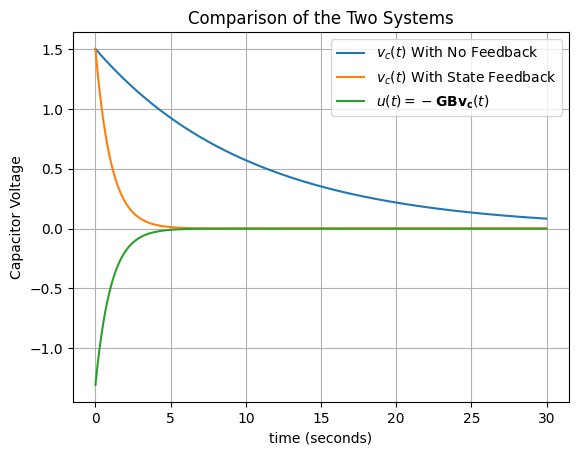

In [5]:
x0 = 1.5
def simulate_state_feedback(circuit, t, G, x0):
    circuit_sfb = ctrl.ss(circuit.A-circuit.B*G, 1, 1, 0)
    tfb, vcfb = ctrl.initial_response(circuit_sfb, t, x0)
    plt.plot(t,vc)
    plt.plot(t,vcfb)
    u = -G*circuit.B*vcfb
    plt.plot(t, u[0])
    plt.grid()
    plt.title("Comparison of the Two Systems")
    plt.xlabel("time (seconds)")
    plt.ylabel("Capacitor Voltage")
    plt.legend(["$v_c(t)$ With No Feedback","$v_c(t)$ With State Feedback","$u(t) = -\mathbf {GBv_c}(t)$"])
    plt.show()

simulate_state_feedback(circuit, t, G, x0)

The charging curve is without feedback, and the discharging curve is with feedback.  If you look closely the discharge curve happens faster.  It changes from charge to discharge every 30 seconds.

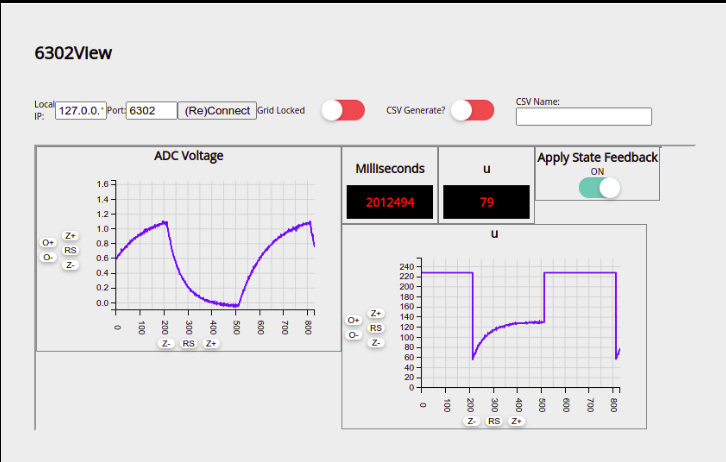

### Linear Quadratic Regulator
The Linear Quadratic Regulator (LGR) minimizes this integral:
$$ J = \int \mathbf{(x^T Q x + u^T R u)}dt $$
by adjusting the state feedback.  In our case, we cannot let the input voltage out of the interval (0, 3.3) Volts.  Often you wish the response to die out as soon as possible, subject to keeping our DAC voltage in range.  This can be accomplished by adjusting the ratio between $\mathbf Q$ and $\mathbf R$.  Decrease R until just before the simulations put the DAC voltage out of range.  The procedure is very similar to using the place routine to place the poles, but we let the LQR algorithm place the poles in order to minimize $J$.

In [10]:
# Don't run this if you want to place the poles instead of having LQR find them for you.
R = 0.01  # Tweak this until the input doesn't leave the interval (-1.5, 1.5) Volts for a reasonable capacitor voltage in the same interval.
Q = 1
G, S, E = ctrl.lqr(circuit, Q, R)
print('G: ', G)
print('The eigenvalues with this state feedback are: ', E)

G:  [[9.04987562]]
The eigenvalues with this state feedback are:  [-0.97194155]


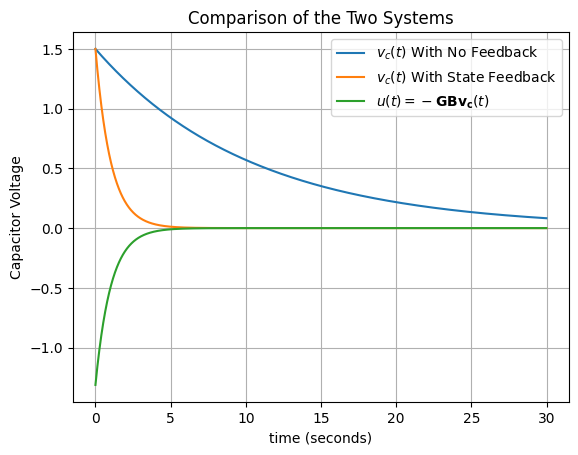

In [12]:
x0 = 1.5
simulate_state_feedback(circuit, t, G, x0)

<a id='observer'></a>

## Full Order Observer

An observer is a control system that is designed to mimic the plant.

The idea is that we would feed the input of the plant with a linear combination of the filtered states, $\mathbf{\hat x}$, instead of the states $\mathbf x$ because they might be better because we don't have to measure all the states, or our simulated states are more accurate than the measured states because of the filtering action of the simulator system relative to noise.  What I mean is $$ \mathbf {u }= \mathbf{-G x}$$ to control the system instead of $\mathbf {u} =  \mathbf {-Gx}$ like we did above, so the system relaxes the way we wish.

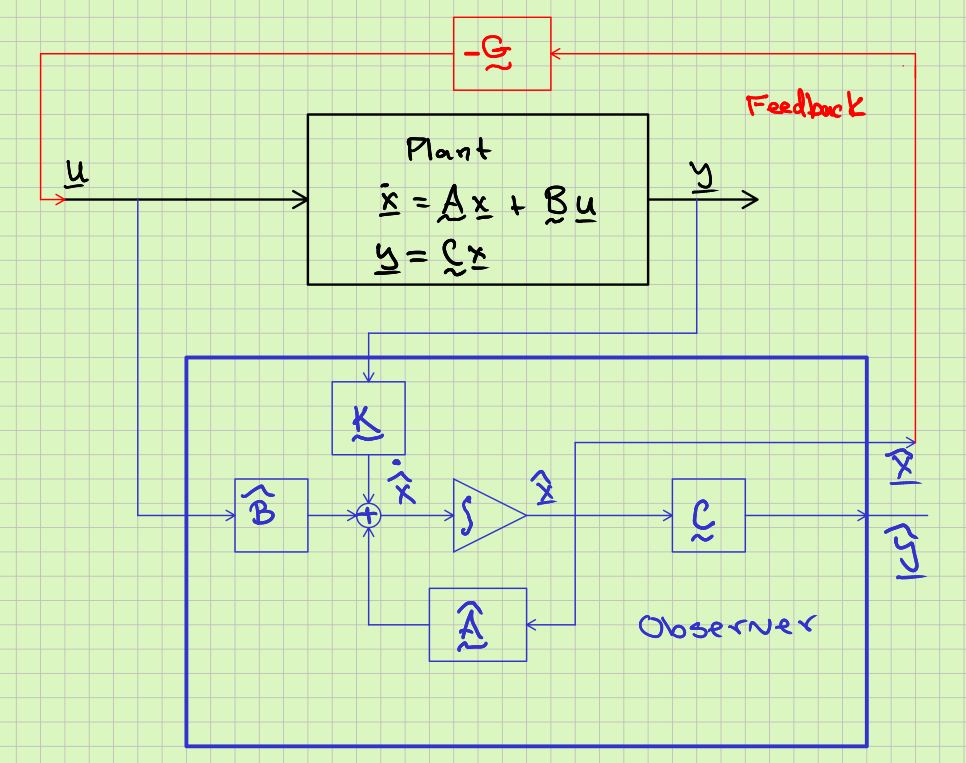

The observer is really a control system that drives the approximation to the state, $\mathbf { \hat x}$ to the true state, $\mathbf x$, quickly.  The idea is that you want the error, $\mathbf e = \mathbf{\hat x - x}$, to approach zero with eigenvalues that are selected by you, so you can make the error disappear as fast as you like.  The basic block diagram (architecture) of the observer was based simply on the idea that the observer is a linear system that is supposed to mimic the plant system, based on the input and output values of the plant. To figure out what the new blocks are, we just write equations for $\mathbf {\hat x}$ and $\mathbf x$ and take the difference to obtain $\mathbf e = \mathbf{\hat x - x}$.  We want the state equations for the state of the error, $\mathbf e$, to be $\mathbf {\dot e} = \mathbf {\tilde A e}$, where we can set the eigenvalues of $\mathbf {\tilde A}$ somehow.  When you do that you find $\mathbf {\hat B = \mathbf B}$ which makes sense because the simulator system should respond to inputs the same way as the plant.  You also find that $\mathbf {\tilde A} = \mathbf {\hat A} = \mathbf {A - KC}$.  This means if you select $\mathbf K$ just right, you could probably select the eigenvalues for $\mathbf { \tilde A }$.

We can make a simulation of the whole system, by writing the state equations for the system and the obsevrer above.  The state will be:  $$\begin{bmatrix} \mathbf{x} \\ \mathbf e \end{bmatrix} = \begin{bmatrix} \mathbf{x} \\ \mathbf {\hat x - x} \end{bmatrix}$$ 

$$\begin{bmatrix} \mathbf{\dot {x}} \\ \mathbf {\dot e} \end{bmatrix}= \begin{bmatrix} \mathbf{\dot x} \\ \mathbf {\hat {\dot x} - \dot {x}} \end{bmatrix} = \begin{bmatrix} \mathbf{A} & \mathbf{0} \\ \mathbf {0} & \mathbf {A-KC} \end{bmatrix} \begin{bmatrix} \mathbf{x} \\ \mathbf {\hat{x} -x} \end{bmatrix} + \begin{bmatrix} \mathbf{0} \\ \mathbf 0 \end{bmatrix}\mathbf u$$

If we use the simulated state for state feedback $\mathbf{u = -Gx}$, and add and subtract $\mathbf{BGx}$ on the right then
$$\begin{bmatrix} \mathbf{\dot {x}} \\ \mathbf {\dot e} \end{bmatrix}= 
\begin{bmatrix} \mathbf{A-BG} & \mathbf{0} \\ \mathbf {0} & \mathbf {A-KC} \end{bmatrix} \begin{bmatrix} \mathbf{x} \\ \mathbf {\hat{x} -x} \end{bmatrix} - \begin{bmatrix} \mathbf{B} \\ \mathbf 0 \end{bmatrix} \mathbf {G \hat {x}} + \mathbf{BGx}$$
$$ = \begin{bmatrix} \mathbf{A-BG} & \mathbf{-BG} \\ \mathbf {0} & \mathbf {A-KC} \end{bmatrix} \begin{bmatrix} \mathbf{x} \\ \mathbf {\hat{x} -x} \end{bmatrix}$$
$$\begin{bmatrix} \mathbf{\dot {x}} \\ \mathbf {\dot e} \end{bmatrix} = \begin{bmatrix} \mathbf{A-BG} & \mathbf{-BG} \\ \mathbf {0} & \mathbf {A-KC} \end{bmatrix} \begin{bmatrix} \mathbf{x} \\ \mathbf {e} \end{bmatrix}$$

From the last equation we see the eigenvalues of the total system are the eigenvalues of $\mathbf {A-BG}$
and those of $\mathbf {A-KC}$.  This means we can design the observer and controller separately!  However, it does not mean that we get the response we would if there was
no observer, because now $\mathbf x$ contains solutions that decay as the eigenvalues of $\mathbf e$ as well.  This handy fact is called the separation principle.

In cases where only some of the state variables are measured, an observer is useful.  It also is very useful when measurements are plagued by noise.  For example, if your sensor differentiates the signal, high-frequency noise can be an issue.  An observer is a system that examines the input and output of a system and uses that information to create a system that mimics the system it is monitoring.  

This is only possible if the original system is observable, meaning the information we have in the output is sufficient.  This happens when the rank of the observability matrix, $\mathbf {R}$, is $n$, where
$$\mathbf R = \begin{bmatrix} \mathbf {C} \\ \mathbf {CA} \\ \mathbf {CA}^2 \\ \vdots \\ \mathbf {CA}^{n-1} \end{bmatrix}$$ 
 and $n$ is the number of states in the system. You can check this easily in python as shown below:

R = ctrl.obsv(circuit.A, circuit.C)
print("R is: ", R)
print("Rank of R is: ", np.linalg.matrix_rank(R))

Since our system is of first order, it is indeed observable.  This basically means we are measuring enough information about the states to figure them out if we watch the input and output.

The next thing to do is to simulate a full-order observer with state feedback.  We can use the matrices state equation of the whole system above.  We assume $\mathbf{ \hat x} = 0$, so $\mathbf{ e = \hat x - x = -x}$.

K is:  [[9.9032882]]
The full response A matrix is: 
[[ -0.32075675  -0.22404495]
 [  0.         -10.        ]]
The eigenvalues:  [ -0.32075675 -10.        ]
The eigenvectors are: 
[[1.         0.02314075]
 [0.         0.99973222]]


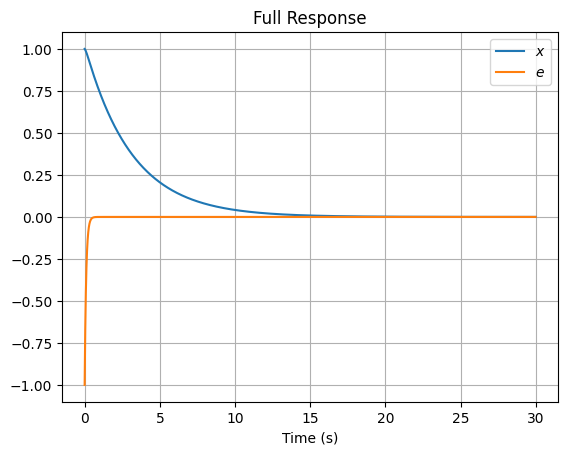

In [8]:
# Put an observer simulator here.

# First decide on the observer poles.
p_o = [-10]  # Faster than the poles of the system after feedback.
K = ctrl.place(np.transpose(circuit.A), np.transpose(circuit.C), p_o)
print('K is: ', K)

def make_full_system(circuit, G, K):
    fullsys = ctrl.ss(np.vstack((np.hstack((circuit.A-np.matmul(circuit.B,G), -np.matmul(circuit.B,G))),np.hstack((
                    np.array([[0]]), circuit.A-np.matmul(K, circuit.C))))),[[0],[0]], np.eye(2),np.zeros((2,1)))
    print('The full response A matrix is: ')
    print(fullsys.A)
    eigs = np.linalg.eig(fullsys.A)
    print('The eigenvalues: ', eigs[0])
    print('The eigenvectors are: ')
    print(eigs[1])
    return fullsys

fullsys = make_full_system(circuit, G, K)
x0 = [[1],[-1]]  # Assumes $\hat{x} = 0$

def simulate_full_sys(fullsys, t, x0):  
    t, xe = ctrl.initial_response(fullsys, t, x0)
    plt.plot(t,xe[0], t, xe[1])
    plt.title('Full Response')
    plt.legend(['$x$', '$e$'])
    plt.xlabel('Time (s)')
    plt.grid()
    
simulate_full_sys(fullsys, t, x0)

### Practical Considerations and the Kalman Filter
The question is, "How do we select the eigenvalues for $\mathbf {\tilde A}$.  If you make the observer respond too quickly, any noise on the output or disturbances to the system will be made worse by the observer because it is relying on the measurements being close to exact.  If you make the observer react slowly, those problems are less, but the error might not approach zero fast enough.  [Rudolph Kalman](https://en.wikipedia.org/wiki/Rudolf_E._K%C3%A1lm%C3%A1n) and [Ruslann Statonovich](https://en.wikipedia.org/wiki/Ruslan_Stratonovich), a Soviet scientist before him, developed an optimal way to do this which minimized $E[( \mathbf{ \hat x - x })^2 ]$, assuming additive white Gaussian noise on the measurement and the input (causing a disturbance). This is called the Kalman filter, and to do it really properly, you need to know the covariances of the disturbances and noises.  It is usually easier to start with an approximation to these than to pick the eigenvalues directly.  In our case, the noise can be approximated as the quantization noise due to the A/D converter.  This is theoretically uniformly distributed over the interval.  The Kalman Filter derivation assumes it is normally distributed, but the wisdom on the street is that is not very important, so we will assume it doesn't matter.  The covariance is the same as the variance for us since there is only one state variable, and for a uniform distribution over one quantization step, it is $q^2/12$ where $q$ is the quantization step.  For us, with a 3.3-Volt range and 12 bits for the ADC, $q_{ADC} = 3.3/2^{12}$.  For the DAC, $q_{DAC}=3.3/2^8$.  

Note to self:  It would be nice to do a derivation of Kalman's filter starting from first principles in the notebook because since the matrices are all one by one, the Riccati equation will be easy to solve.

Qn:  5.4091215133666984e-08 
RN:  1.3847351074218748e-05
K is:  [[0.00018871]]
The full response A matrix is: 
[[-0.32075675 -0.22404495]
 [ 0.         -0.0969005 ]]
The eigenvalues:  [-0.32075675 -0.0969005 ]
The eigenvectors are: 
[[ 1.         -0.70740463]
 [ 0.          0.70680881]]


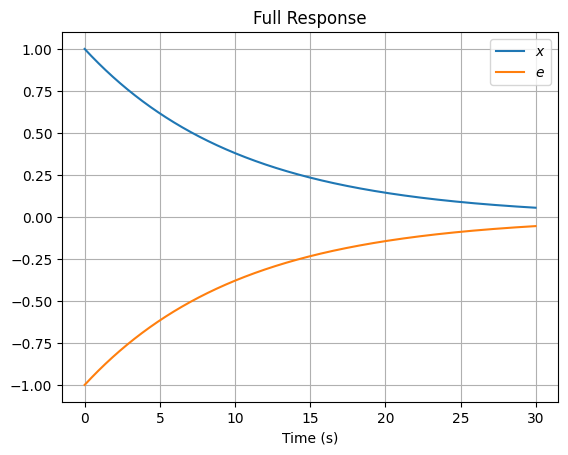

In [9]:
QN = ((3.3/(2**12))**2)/12
RN = ((3.3/(2**8))**2)/12
print('Qn: ', QN, '\nRN: ', RN)
K, P, E = ctrl.lqe(circuit, QN, RN)  # New optimum K for Kalman Filter
print('K is: ', K)
fullsys = make_full_system(circuit, G, K)
x0 = [[1],[-1]]
simulate_full_sys(fullsys, t, x0)

At first something appears wrong here because we expect $x$ to decay according to the eigenvalue we set with place (or the LQR) and it is not decaying as $e^{-.967t}$ as we designed it to.  However, we have to recall that $x$ is a linear combination of both eigenvectors.  In cases when we set the poles of the observer to decay much faster than we want $x$ to it does not matter much, but when the Kalman Filter poles are not fast, then we get this kind of thing.  You can set the x0 = [[1],[0]] the error is always zero, and $x$ decays the way we expect. We need to remember this when we are using an observer.

For our capacitor voltage control problem here, the slow response of the Kalman Filter makes you wonder about your control system design.  If the primary objective was to make the capacitor voltage decay fast, then by using the Kalman Filter, you have "shot yourself in the foot", because it will almost never decay as fast as you wish.  Remember that the Kalman observer is designed to minimize the $\mathbf{E[(\hat x -x)^2]}$, without regard to your desire to control the system to decay quickly.  In this case, using a Kalman Filter would be a bad idea.  You would be much better off using the measured state (which isn't that far from perfect, as it is a 12-bit ADC) instead of the Kalman observed state.  The Kalman filter's objective is to minimize the difference between $\hat x$ and $x$ at this specific time, not the integral over time.  It prefers to be a tiny bit wrong forever rather than being terrible for a minute, and perfect forever thereafter.

#### Kalman Filter for Measurement Only
So would a Kalman Filter be useful to improve the measurement of the capacitor voltage decay if you were using the measured voltage as the feedback quantity (not the Kalman estimate)?  I think so, but only if you used the new after-feedback system model to design the filter (not the A matrix before).  Please note that this situation does not exactly match the situation you have, because of the state feedback with ADC and DAC noise.  You would get a better filter if you took the ADC noise and figured its effect on the input and added it to the DAC and used that as the DAC noise in your design of the Kalman Filter.